In [496]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import itertools
%matplotlib widget

In [497]:
class NuclearLattice(nn.Module):
    
    """
    Class representing a nuclear lattice simulation
    """
    def __init__(self, N, Z, lattice_width=10, state_space_dim=2):
        super().__init__()
        self.N = N
        self.Z = Z 
        self.A = N + Z
        
        self.lattice_width = lattice_width
        self.state_space_dim = state_space_dim
        self.boundaries = torch.tensor(state_space_dim * [[-lattice_width//2, lattice_width//2]] + [[-0.5, 0.5]])
        self.lattice_shape = torch.tensor([int(bound[1] - bound[0] + 1) for bound in self.boundaries])
        
        self.states = self._dense_initialization(N, Z, state_space_dim)
    
    """
    Initializes every neutron and proton directly at the origin with spin = isospin
    """
    def _dense_initialization(self, N, Z, state_space_dim):      
        neutron_positions = torch.zeros((N, state_space_dim))
        neutron_spins = torch.zeros((N, 1)) - 0.5
        neutron_isospins = torch.zeros((N, 1)) - 0.5
        neutron_states = torch.hstack((neutron_positions, neutron_spins, neutron_isospins))

        proton_positions = torch.zeros((Z, state_space_dim))
        proton_spins = torch.zeros((Z, 1)) + 0.5
        proton_isospins = torch.zeros((Z, 1)) + 0.5
        proton_states = torch.hstack((proton_positions, proton_spins, proton_isospins))
        
        return torch.vstack((neutron_states, proton_states))

    """
    Pauli blocking prevents any two nucleons with identical quantum numbers
    """
    def pauli_blocking(self, r1, spin1, isospin1, r2, spin2, isospin2):
        state_dist = torch.linalg.norm(r1 - r2) + torch.abs(spin1 - spin2) + torch.abs(isospin1 - isospin2)
        if state_dist < 1e-3:
            return True
        else:
            return False

    """
    Takes an interaction term f_interaction(r1, s1, i1, r2, s2, i2) -> energy and computes E_i = sum_j f_interaction(r_i, s_i, i_i, r_j, s_j, i_j)
    """
    def _get_E_i(self, i, state_i, f_interaction):
        r_i = state_i[0:self.state_space_dim]
        spin_i = state_i[-2]
        isospin_i = state_i[-1]

        E_i = 0.0
        for j in range(self.A):
            if i == j:
                continue
            r_j = self.states[j,0:self.state_space_dim]
            spin_j = self.states[j,-2]
            isospin_j = self.states[j,-1]
            if self.pauli_blocking(r_i, spin_i, isospin_i, r_j, spin_j, isospin_j):
                return torch.tensor([torch.inf])
            E_i += f_interaction(r_i, spin_i, isospin_i, r_j, spin_j, isospin_j)
        return E_i

    """
    For every point in the lattice, temporarily moves nucleon i to that point and computes E_i from that point.
    """
    def _get_E_i_lattice(self, i, f_interaction):
        state = self.states[i]
        
        E_i_lattice = torch.zeros(*self.lattice_shape)
        # iterates over every possible state space position and spin within bounds
        for lattice_idx in itertools.product(*[range(shape) for shape in self.lattice_shape]):
            state[0:-1] = self.boundaries[:,0] + torch.tensor(lattice_idx)
            E_i_lattice[lattice_idx] = self._get_E_i(i, state, f_interaction)

        return E_i_lattice        
    
    """
    
    """
    def step(self, f_interaction):
        for i in range(self.A):
            E_i_lattice = self._get_E_i_lattice(i, f_interaction)
            best_idx = torch.unravel_index(torch.argmin(E_i_lattice), E_i_lattice.shape)
            best_location = self.boundaries[:,0] + torch.tensor(best_idx)
            self.states[i][0:-1] = best_location
        return self.E_tot(f_interaction)

    """
    Computes the total energy of the system
    """
    def E_tot(self, f_interaction):
        E_tot = 0.0
        for i in range(self.A):
            for j in range(i, self.A):
                if i == j:
                    continue
                r_i, spin_i, isospin_i = self.states[i,0:self.state_space_dim], self.states[i,-2], self.states[i,-1]
                r_j, spin_j, isospin_j = self.states[j,0:self.state_space_dim], self.states[j,-2], self.states[j,-1]
                E_tot += f_interaction(r_i, spin_i, isospin_i, r_j, spin_j, isospin_j)
        return E_tot


In [498]:
def f_interaction(r1, spin1, isospin1, r2, spin2, isospin2):
    r = torch.linalg.norm(r1- r2)
    E = 0.0
    a = 3
    b = 0.5
    if r > 1:
        E += a/r**2.0 + 0.5*(1 + 2*spin1*spin2)*r
    else:
        E += a + 0.5*(1 + 2*spin1*spin2)
    if isospin1 > 0 and isospin2 > 0:
        E += b / r**2.0
    return E

In [518]:
N, Z = 2, 2
lattice = NuclearLattice(N, Z, lattice_width=10, state_space_dim=3)

In [519]:
prev_E_tot = torch.inf
E_tot = 1e9
while E_tot < prev_E_tot:
    prev_E_tot = E_tot
    E_tot = lattice.step(f_interaction)
    print(E_tot)

tensor(9.0423)
tensor(8.9749)
tensor(8.9749)


(-5.0, 5.0)

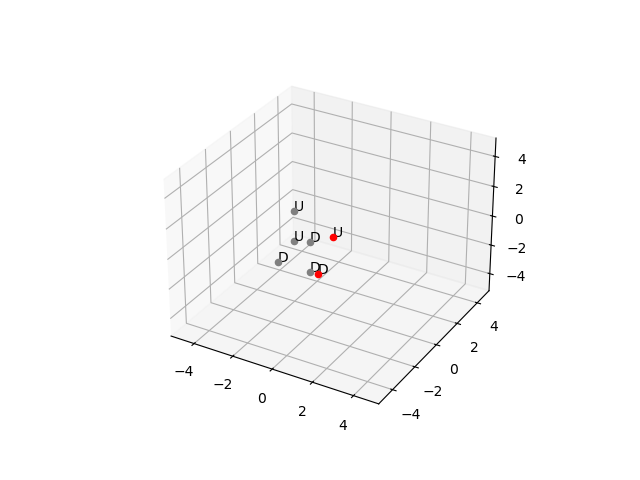

In [516]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

isospin_color = ["grey", "red"]
spin_text = ["D", "U"]
for state in lattice.states.detach():
    ax.scatter(state[0], state[1], state[2], color=isospin_color[int(state[-1] + 0.5)])
    ax.text(state[0], state[1], state[2], spin_text[int(state[-2] + 0.5)])

ax.set_xlim(*lattice.boundaries[0])
ax.set_ylim(*lattice.boundaries[1])
ax.set_zlim(*lattice.boundaries[2])

In [303]:
lattice.states

tensor([[10.0000, 33.0000,  0.5000, -0.5000],
        [ 7.0000, 34.0000,  0.5000, -0.5000],
        [ 7.0000, 32.0000,  0.5000, -0.5000],
        [ 8.0000, 32.0000, -0.5000, -0.5000],
        [ 7.0000, 31.0000, -0.5000, -0.5000],
        [ 9.0000, 33.0000, -0.5000, -0.5000],
        [ 8.0000, 30.0000, -0.5000, -0.5000],
        [ 6.0000, 32.0000, -0.5000, -0.5000],
        [ 8.0000, 33.0000,  0.5000, -0.5000],
        [ 7.0000, 33.0000, -0.5000,  0.5000],
        [ 9.0000, 32.0000,  0.5000,  0.5000],
        [10.0000, 31.0000,  0.5000,  0.5000],
        [ 9.0000, 34.0000,  0.5000,  0.5000],
        [ 9.0000, 31.0000, -0.5000,  0.5000]])